In [1]:
import pickle
import sys
import os
from typing import Optional

# Fix module search path to allow unpickling of app.common or common classes
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "../../"))
app_dir = os.path.join(project_root, "app")

if project_root not in sys.path:
    sys.path.append(project_root)
if app_dir not in sys.path:
    sys.path.append(app_dir)

try:
    from app.common.models import PhotoMeta
except ImportError:
    try:
        from common.models import PhotoMeta
    except ImportError:
        # Fallback if running outside of app context and modules not found
        from dataclasses import dataclass
        @dataclass
        class PhotoMeta:
            path: str
            lat: Optional[float] = None
            lon: Optional[float] = None
            timestamp: Optional[float] = None

def load_dataset(path: str) -> dict:
    with open(path, "rb") as f:
        return pickle.load(f)

In [2]:
dataset_path = "/Users/aohus/Workspaces/github/job-report-creator/cluster-backend/experiment/optimize_features/features/dataset_cache_vertex_masking.pkl"
data = load_dataset(dataset_path)
photos = data['photos']
features = data['features']

In [3]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

def find_similar_photos(target_idx: int, photos: list, features: np.ndarray, top_k: int = 5):
    target_vector = features[target_idx].reshape(1, -1)
    similarities = cosine_similarity(target_vector, features)[0]
    
    # Get top K indices (excluding itself)
    top_indices = similarities.argsort()[::-1][:top_k+1]
    
    print(f"Target Photo: {photos[target_idx].path}")
    
    # Display target photo
    plt.figure(figsize=(5, 5))
    try:
        plt.imshow(Image.open(photos[target_idx].path))
        plt.title("Target Photo")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not load target image: {e}")
    
    print(f"\nTop {top_k} Similar Photos:")
    count = 0
    for idx in top_indices:
        if idx == target_idx:
            continue
            
        score = similarities[idx]
        photo_path = photos[idx].path
        print(f"Score: {score:.4f} - {photo_path}")
        
        plt.figure(figsize=(5, 5))
        try:
            plt.imshow(Image.open(photo_path))
            plt.title(f"Score: {score:.4f}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Could not load image {photo_path}: {e}")
        
        count += 1
        if count >= top_k:
            break


In [4]:
# # Example Usage: Find similar photos for the first photo in the dataset
# target_index = 0 # Change this index to select a different photo
# if len(photos) > target_index:
#     find_similar_photos(target_index, photos, features, top_k=5)
# else:
#     print("Dataset is empty or index out of bounds.")

In [5]:
# Add current directory to path to allow importing clusters.py
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

try:
    from clusters import TunableHybridCluster
except ImportError as e:
    print(f"Error importing TunableHybridCluster: {e}")
    print("Ensure clusters.py is in the same directory and app.common.models is accessible.")

def analyze_clustering_results(photos, features):
    print("Initializing Clustering with TunableHybridCluster...")
    
    # Default params matching clusters.py defaults or reasonable values
    params = {
        'max_gps_tol': 40.0,
        'loose_thresh': 0.5,
        'min_cluster_size': 2,
        'min_samples': 2
    }
    
    try:
        clusterer = TunableHybridCluster(params)
        labels = clusterer.run_clustering(photos, features)
    except Exception as e:
        print(f"Clustering failed: {e}")
        return
        
    unique_labels = set(labels)
    # Exclude noise (-1) from count
    clusters = [l for l in unique_labels if l != -1]
    n_clusters = len(clusters)
    n_noise = list(labels).count(-1)
    
    print(f"\n--- Clustering Report ---")
    print(f"Total Photos: {len(photos)}")
    print(f"Clusters Found: {n_clusters}")
    print(f"Noise Points: {n_noise}")
    
    # Visualization
    # Group indices by label
    cluster_dict = {}
    for idx, label in enumerate(labels):
        if label not in cluster_dict:
            cluster_dict[label] = []
        cluster_dict[label].append(idx)
    
    # Sort clusters by size (descending)
    sorted_labels = sorted(clusters, key=lambda l: len(cluster_dict[l]), reverse=True)
    
    # Show top 5 clusters
    for i, label in enumerate(sorted_labels[:5]):
        indices = cluster_dict[label]
        print(f"\nCluster ID {label}: {len(indices)} photos")
        
        # Show first 5 images of the cluster
        plt.figure(figsize=(15, 3))
        for j, idx in enumerate(indices[:5]):
            photo = photos[idx]
            plt.subplot(1, 5, j+1)
            try:
                img = Image.open(photo.path)
                plt.imshow(img)
                plt.title(f"{os.path.basename(photo.path)}", fontsize=8)
                plt.axis('off')
            except Exception as e:
                print(f"Error: {e}")
        plt.tight_layout()
        plt.show()
    
    if n_noise > 0:
        print(f"\nNoise Points (Sample):")
        indices = cluster_dict[-1]
        plt.figure(figsize=(15, 3))
        for j, idx in enumerate(indices[:5]):
            photo = photos[idx]
            plt.subplot(1, 5, j+1)
            try:
                img = Image.open(photo.path)
                plt.imshow(img)
                plt.title(f"Noise: {os.path.basename(photo.path)}", fontsize=8)
                plt.axis('off')
            except Exception as e:
                print(f"Error: {e}")
        plt.tight_layout()
        plt.show()


Initializing Clustering with TunableHybridCluster...

--- Clustering Report ---
Total Photos: 872
Clusters Found: 308
Noise Points: 34

Cluster ID 355: 10 photos


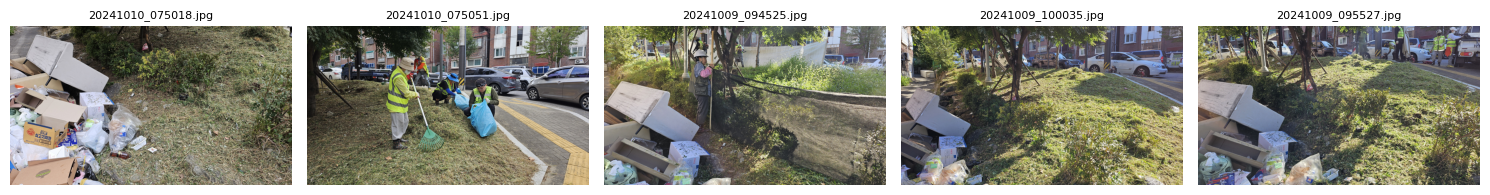


Cluster ID 352: 6 photos


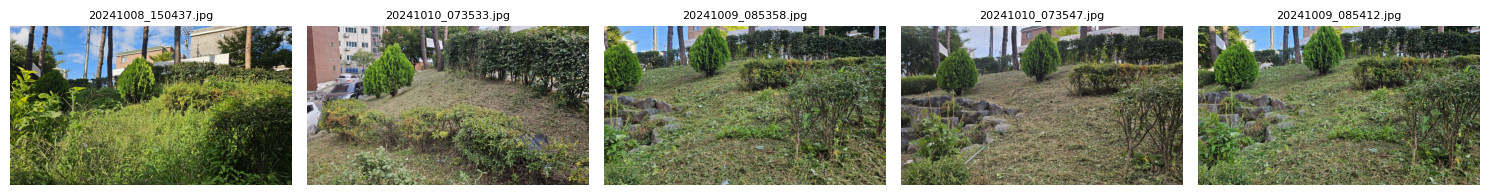


Cluster ID 10: 4 photos


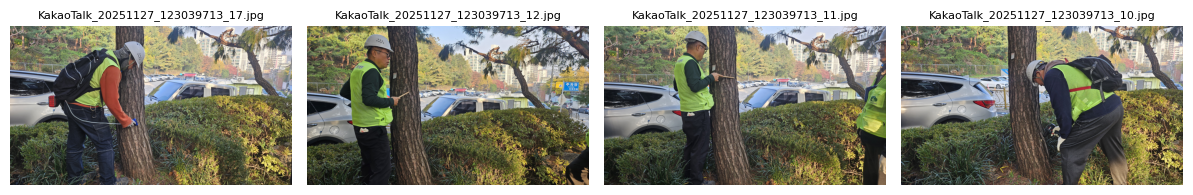


Cluster ID 23: 4 photos


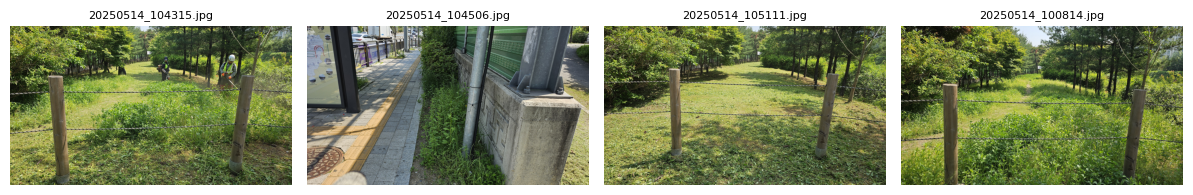


Cluster ID 31: 4 photos


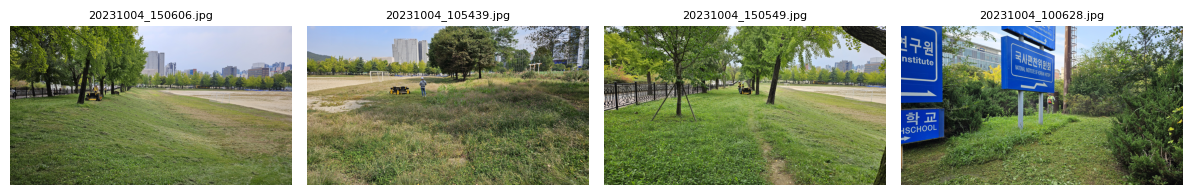


Noise Points (Sample):


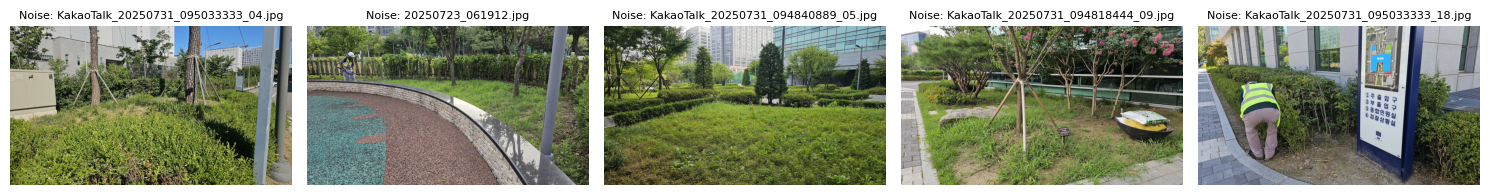

In [6]:
# Execute clustering analysis
if 'photos' in locals() and 'features' in locals():
    analyze_clustering_results(photos, features)
else:
    print("Photos or features not loaded. Run previous cells first.")